# Visual Modality: Video Features

Used pytorch pretrained R(2+1)-18 model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install av
!mkdir data/
!unzip drive/My\ Drive/mmml-data/subsetVideo.zip -d data/
!unzip drive/My\ Drive/mmml-data/data_mosei.zip -d data/
!unzip drive/My\ Drive/mmml-data/timestamps.zip -d data/

## Get features and labels

In [ ]:
import torch
import torchvision
import glob
import numpy as np

In [ ]:
# load model
torch.cuda.empty_cache()
model = torchvision.models.video.r2plus1d_18(pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


In [ ]:
# grab a video sample
video_frames, _, metadata = torchvision.io.read_video('data/subsetVideo/0OXeN3MhFeA_16.mp4', pts_unit='sec')

In [ ]:
video_frames.shape # T x H x W x C

torch.Size([41, 720, 1280, 3])

In [ ]:
metadata

{'audio_fps': 44100, 'video_fps': 30.0}

In [ ]:
# source: https://github.com/pytorch/vision/blob/master/references/video_classification/transforms.py
# exclusive transforms for processing videos
from transforms import ToFloatTensorInZeroOne, Resize, CenterCrop, Normalize

transform = torchvision.transforms.Compose([
    ToFloatTensorInZeroOne(),
    Resize(112),
    CenterCrop((112, 112)),
    Normalize(
        mean=[0.43216, 0.394666, 0.37645],
        std=[0.22803, 0.22145, 0.216989]
    )
])

In [ ]:
transformed_video = transform(video_frames).unsqueeze(0).cuda()
transformed_video.shape # batch_size x channel x time x height x width

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([1, 3, 41, 112, 112])

In [ ]:
features = model(transformed_video)
features.shape

torch.Size([1, 400])

In [ ]:
# get features for videos
all_features = []
video_ids = []

for video_path in glob.glob('data/subsetVideo/*.mp4'):
    frames, _, _ = torchvision.io.read_video(video_path, pts_unit='sec')
    num_frames = frames.shape[0]
    if num_frames == 0 or num_frames > 180:
        continue # only get videos of 0~6s to avoid OOM (actual usage ~15G)

    model_input = transform(frames).unsqueeze(0).cuda()
    features = model(model_input).detach().cpu().numpy()
    all_features.append(features)
    video_ids.append(video_path.split('/')[-1])
    print('video {}: {} frames'.format(len(all_features), num_frames))

all_features = np.array(all_features)

In [ ]:
len(video_ids)

886

In [ ]:
# get labels
import pickle
import os

dataroot = '/content/data'
y_train_file = os.path.join(dataroot, "Y_S_train.pkl")
y_valid_file = os.path.join(dataroot, "Y_S_valid.pkl")
y_test_file = os.path.join(dataroot, "Y_S_test.pkl")
key_to_sentiment_train = pickle.load(open(y_train_file, "rb"))
key_to_sentiment_valid = pickle.load(open(y_valid_file, "rb"))
key_to_sentiment_test = pickle.load(open(y_test_file, "rb"))

In [ ]:
labels = []

for video_id in video_ids:
    video_id = video_id.split('.')[0]
    idx = video_id.rfind("_")
    key = video_id[:idx] + '[' + video_id[idx+1:] + ']'
    label = key_to_sentiment_train.get(key, None) or \
            key_to_sentiment_valid.get(key, None) or \
            key_to_sentiment_test.get(key, None)
    labels.append(label)

labels = np.array(labels)

In [ ]:
print('label hit rate = {}'.format((labels != None).sum() / len(labels)))

label hit rate = 0.39164785553047404


## Visualization

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
all_features.shape

(886, 1, 400)

In [ ]:
# t-sne embeddings
all_features_squeezed = all_features.reshape(-1, 400)
tsne_model = TSNE(n_components=2, perplexity=50, random_state=42)
X_embedded = tsne_model.fit_transform(all_features_squeezed)
X_embedded.shape

(886, 2)

In [ ]:
filtered_labels = labels[labels != None]
filtered_embeddings = X_embedded[labels != None]

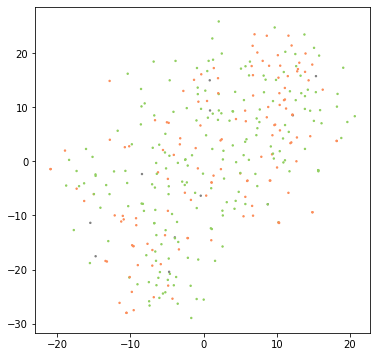

In [ ]:
color_labels = []
for l in filtered_labels:
  if l > 0:
    color_labels.append('#91cf60')
  elif l < 0:
    color_labels.append('#fc8d59')
  else:
    color_labels.append('grey')

plt.figure(figsize=(6, 6))
plt.scatter(filtered_embeddings[:, 0], filtered_embeddings[:, 1], c=color_labels, s=2)

# Visual Modality: MOSEI Features

In [ ]:
!git clone https://github.com/A2Zadeh/CMU-MultimodalSDK
!pip install h5py validators tqdm requests colorama

In [31]:
import os
os.chdir('/content/CMU-MultimodalSDK')
from mmsdk import mmdatasdk

In [ ]:
cmumosei_highlevel = mmdatasdk.mmdataset(mmdatasdk.cmu_mosei.highlevel, 'cmu-mosei/')
# cmumosei_highlevel = mmdatasdk.mmdataset('cmu-mosei/')

In [47]:
import random
import numpy as np
import pandas as pd
import pickle

dataroot = '/content/data'
y_train_file = os.path.join(dataroot, "Y_S_train.pkl")
y_valid_file = os.path.join(dataroot, "Y_S_valid.pkl")
y_test_file = os.path.join(dataroot, "Y_S_test.pkl")
key_to_sentiment_train = pickle.load(open(y_train_file, "rb"))
key_to_sentiment_valid = pickle.load(open(y_valid_file, "rb"))
key_to_sentiment_test = pickle.load(open(y_test_file, "rb"))

In [50]:
def get_features(highlevel_features):
    random.seed(42)

    all_features = []
    labels = []

    # randomly pick one clip for each video
    # an average is taken across all frames for a clip
    for video_id in highlevel_features.keys():
        timestamps = pd.read_csv("/content/data/Combined/{}.txt".format(video_id), header=None, sep='___', engine='python',
                                usecols=[0, 1, 2, 3], names=['video_id', 'clip_id', 'start', 'end'])
        row = random.randrange(timestamps.shape[0])
        start = timestamps.loc[row, 'start']
        end = timestamps.loc[row, 'end']

        key = video_id + '[' + str(0) + ']'
        label = key_to_sentiment_train.get(key, None) or \
                key_to_sentiment_valid.get(key, None) or \
                key_to_sentiment_test.get(key, None)
        if label is None:
            continue

        intervals = highlevel_features[video_id]['intervals'][:]
        start_idx = (np.argmax(intervals >= start) + 1) // 2
        end_idx = np.argmax(intervals >= end) // 2
        if start_idx >= end_idx:
            continue
        features = highlevel_features[video_id]['features'][start_idx:end_idx].mean(axis=0)

        all_features.append(features)
        labels.append(label)

        if len(labels) % 50 == 0:
            print(len(labels))
        if len(labels) == 500:
            break

    return np.array(all_features), labels

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(all_features, labels):
    tsne_model = TSNE(n_components=2, perplexity=50, random_state=42)
    X_embedded = tsne_model.fit_transform(all_features)
    print('shape before: ', all_features.shape)
    print('shape after: ', X_embedded.shape)

    color_labels = []
    for l in labels:
        if l > 0:
            color_labels.append('#91cf60')
        elif l < 0:
            color_labels.append('#fc8d59')
        else:
            color_labels.append('grey')

    plt.figure(figsize=(6, 6))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color_labels, s=2)

In [ ]:
all_features, labels = get_features(cmumosei_highlevel['OpenFace_2'])

shape before:  (500, 713)
shape after:  (500, 2)


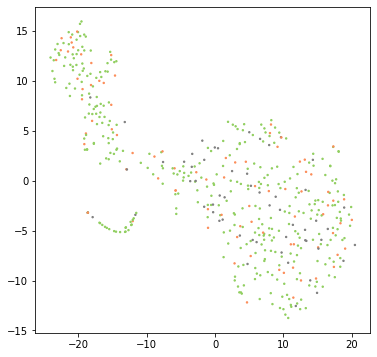

In [53]:
visualize(all_features, labels)

In [ ]:
all_features, labels = get_features(cmumosei_highlevel['FACET 4.2'])

shape before:  (500, 35)
shape after:  (500, 2)


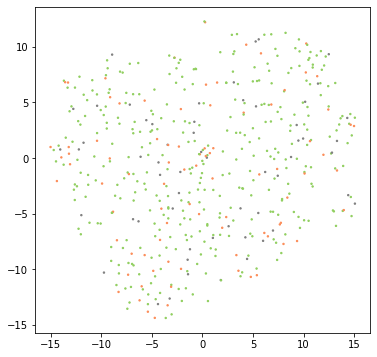

In [55]:
visualize(all_features, labels)